In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")

In [38]:
# Load the Training Dataset
train = pd.read_excel('credit-data-training.xlsx')  
print(f"The training dataset has {train.shape[0]} rows and {train.shape[1]} columns.")
print(train.head())

The training dataset has 500 rows and 20 columns.
  Credit-Application-Result Account-Balance  Duration-of-Credit-Month  \
0              Creditworthy    Some Balance                         4   
1              Creditworthy    Some Balance                         4   
2              Creditworthy    Some Balance                         4   
3              Creditworthy    Some Balance                         4   
4              Creditworthy      No Account                         6   

  Payment-Status-of-Previous-Credit       Purpose  Credit-Amount  \
0                           Paid Up         Other           1494   
1                           Paid Up  Home Related           1494   
2        No Problems (in this bank)  Home Related           1544   
3        No Problems (in this bank)  Home Related           3380   
4                           Paid Up  Home Related            343   

  Value-Savings-Stocks Length-of-current-employment  Instalment-per-cent  \
0           £100-£1000    

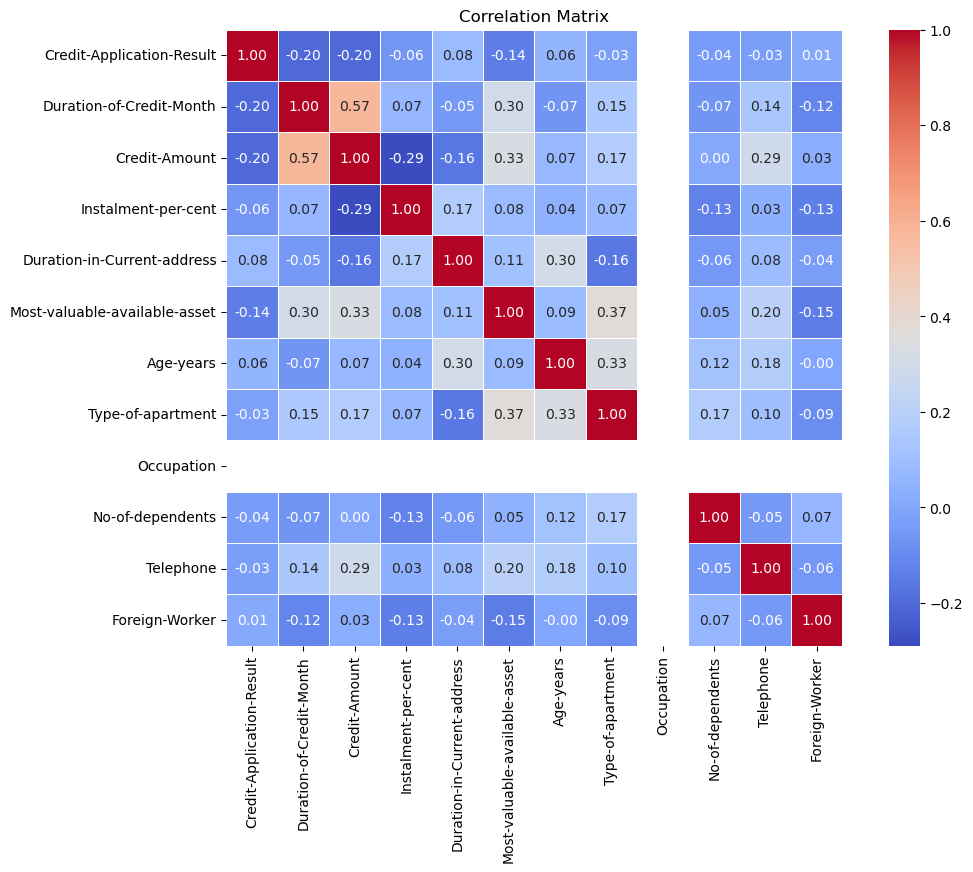

In [39]:
# Correlation Analysis
train['Credit-Application-Result'] = train['Credit-Application-Result'].replace({'Creditworthy': 1, 'Non-Creditworthy': 0})

correlation_matrix = train.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Missing values in each column:
 Account-Balance                        0
Duration-of-Credit-Month               0
Payment-Status-of-Previous-Credit      0
Purpose                                0
Credit-Amount                          0
Value-Savings-Stocks                   0
Length-of-current-employment           0
Instalment-per-cent                    0
Guarantors                             0
Duration-in-Current-address          344
Most-valuable-available-asset          0
Age-years                             12
Concurrent-Credits                     0
Type-of-apartment                      0
No-of-Credits-at-this-Bank             0
Occupation                             0
No-of-dependents                       0
Telephone                              0
Foreign-Worker                         0
dtype: int64


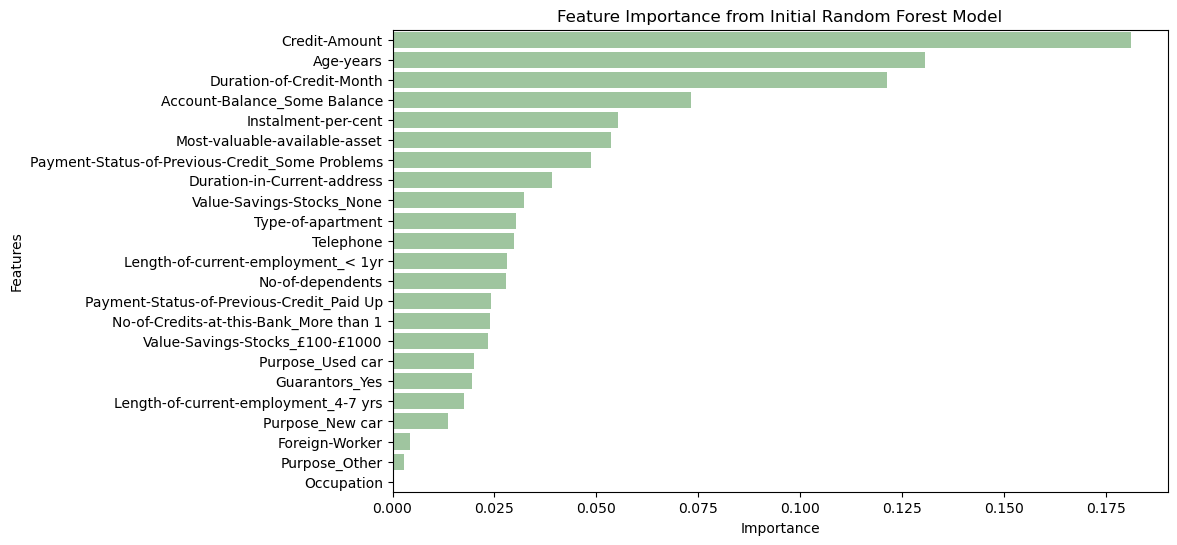

Features with Low Importance (less than 5%):
                                           Features  Importance
13  Payment-Status-of-Previous-Credit_Some Problems    0.048655
3                       Duration-in-Current-address    0.039030
17                        Value-Savings-Stocks_None    0.032149
6                                 Type-of-apartment    0.030167
9                                         Telephone    0.029905
20               Length-of-current-employment_< 1yr    0.028083
8                                  No-of-dependents    0.027736
12        Payment-Status-of-Previous-Credit_Paid Up    0.024094
22           No-of-Credits-at-this-Bank_More than 1    0.023967
18                  Value-Savings-Stocks_£100-£1000    0.023457
16                                 Purpose_Used car    0.019947
21                                   Guarantors_Yes    0.019400
19             Length-of-current-employment_4-7 yrs    0.017647
14                                  Purpose_New car    0.01

In [40]:
#Data preprocessing

X = train.drop('Credit-Application-Result', axis=1)  # Features
y = train['Credit-Application-Result']  # Target variable

# Check for missing values
print("Missing values in each column:\n", X.isnull().sum())

# Separate numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Impute missing values for numeric features with mean
numeric_imputer = SimpleImputer(strategy='mean')
X[numeric_features] = numeric_imputer.fit_transform(X[numeric_features])

# Impute missing values for categorical features with mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_features] = categorical_imputer.fit_transform(X[categorical_features])

# Convert categorical features to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Train a Random Forest model for initial feature importance
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X, y)

# Get feature importances
importances = rfc.feature_importances_
feature_importance_df = pd.DataFrame({'Features': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Features', data=feature_importance_df, color='g', alpha=0.4)
plt.title('Feature Importance from Initial Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Display the features with low importance
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < 0.05]
print("Features with Low Importance (less than 5%):")
print(low_importance_features)

# Dropping less important features based on EDA
features_to_drop = low_importance_features['Features'].tolist()
print(f"Dropping the following features due to low importance: {features_to_drop}")
X.drop(columns=features_to_drop, inplace=True)

# Display the shape of X after dropping low importance features
print(f"Shape of X after dropping low importance features: {X.shape}")

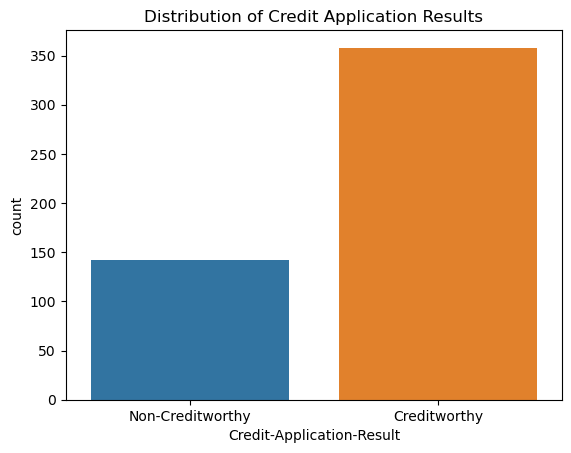

In [41]:
# Countplot for target variable 
sns.countplot(x='Credit-Application-Result', data=train)
plt.title('Distribution of Credit Application Results')
plt.xticks(ticks=[0, 1], labels=['Non-Creditworthy', 'Creditworthy'])
plt.show()

In [46]:
train.dtypes

Credit-Application-Result                            int64
Duration-of-Credit-Month                             int64
Credit-Amount                                        int64
Instalment-per-cent                                  int64
Guarantors                                          object
Duration-in-Current-address                        float64
Most-valuable-available-asset                        int64
Age-years                                          float64
Concurrent-Credits                                  object
Type-of-apartment                                    int64
Occupation                                           int64
No-of-dependents                                     int64
Telephone                                            int64
Foreign-Worker                                       int64
Account-Balance_Some Balance                         uint8
Payment-Status-of-Previous-Credit_Paid Up            uint8
Payment-Status-of-Previous-Credit_Some Problems      uin

In [45]:
# Splitting the Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest Classifier before Hyperparameter Tuning
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
print('Train Score before tuning: {:.2f}'.format(rfc.score(X_train, y_train)))
print('Test Score before tuning: {:.2f}'.format(rfc.score(X_test, y_test)))

# Hyperparameter tuning for Random Forest Classifier
param_grid = {
    'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_leaf_nodes': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}
grid_rfc = GridSearchCV(rfc, param_grid=param_grid, cv=5)
grid_rfc.fit(X_train, y_train)

print('Best cross-validation accuracy: {:.2f}'.format(grid_rfc.best_score_))
print('Best test score after tuning: {:.2f}'.format(grid_rfc.score(X_test, y_test)))
print('Best parameters:', grid_rfc.best_params_)

# Random Forest Classifier after Hyperparameter Tuning
best_params = grid_rfc.best_params_
rfc_tuned = RandomForestClassifier(max_features=best_params['max_features'], 
                                    max_leaf_nodes=best_params['max_leaf_nodes'], 
                                    random_state=0)
rfc_tuned.fit(X_train, y_train)

print('Train Score after tuning: {:.2f}'.format(rfc_tuned.score(X_train, y_train)))
print('Test Score after tuning: {:.2f}'.format(rfc_tuned.score(X_test, y_test)))

Train Score before tuning: 1.00
Test Score before tuning: 0.78
Best cross-validation accuracy: 0.77
Best test score after tuning: 0.76
Best parameters: {'max_features': 2, 'max_leaf_nodes': 8}
Train Score after tuning: 0.81
Test Score after tuning: 0.76


In [47]:
# Predictions
rfc_y_pred = rfc_tuned.predict(X_test)

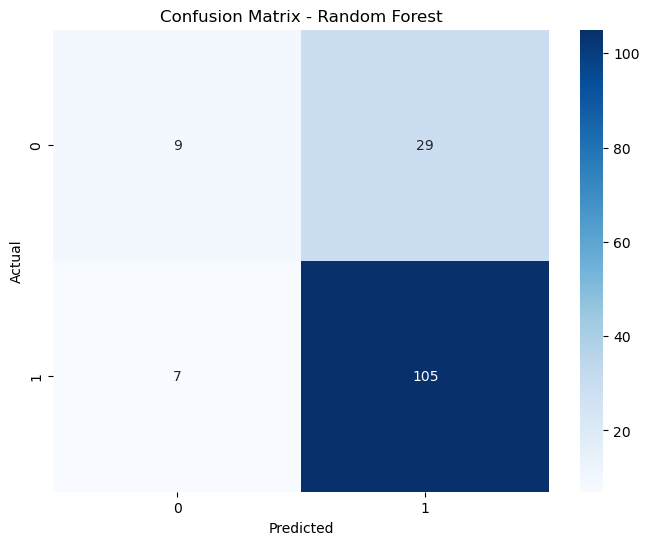

In [48]:
# Confusion Matrix
rf_cm = confusion_matrix(y_test, rfc_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

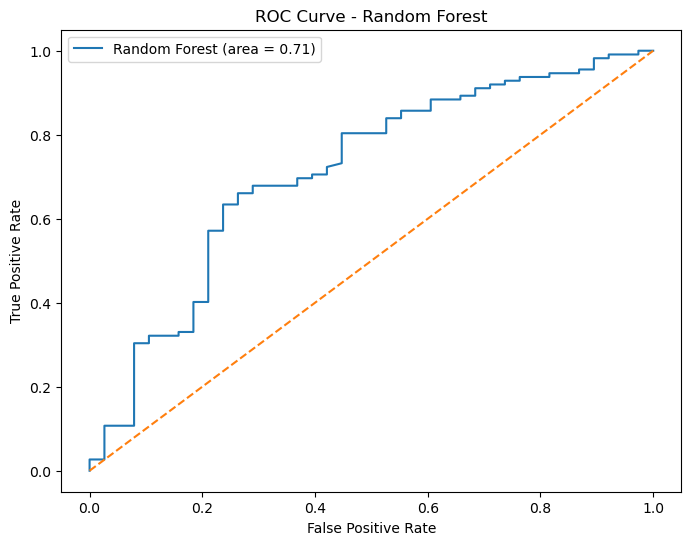

In [49]:
# ROC Curve
roc_auc = roc_auc_score(y_test, rfc_tuned.predict_proba(X_test)[:, 1])
fpr, tpr, _ = roc_curve(y_test, rfc_tuned.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

In [25]:
#Implementing the Model on Test Data
test_data = pd.read_excel('customers-to-score.xlsx')
print("Test Data Sample:\n", test_data.head(3))

Test Data Sample:
   Account-Balance  Duration-of-Credit-Month Payment-Status-of-Previous-Credit  \
0      No Account                         9        No Problems (in this bank)   
1      No Account                        12        No Problems (in this bank)   
2      No Account                        24                           Paid Up   

        Purpose  Credit-Amount Value-Savings-Stocks  \
0  Home Related           2799                 None   
1  Home Related           2122                 None   
2  Home Related           3758           £100-£1000   

  Length-of-current-employment  Instalment-per-cent Guarantors  \
0                        < 1yr                    2       None   
1                        < 1yr                    3       None   
2                        < 1yr                    1       None   

   Duration-in-Current-address  Most-valuable-available-asset  Age-years  \
0                            2                              1         36   
1                 

In [26]:
print("Missing values in test data:\n", test_data.isnull().sum())

Missing values in test data:
 Account-Balance                      0
Duration-of-Credit-Month             0
Payment-Status-of-Previous-Credit    0
Purpose                              0
Credit-Amount                        0
Value-Savings-Stocks                 0
Length-of-current-employment         0
Instalment-per-cent                  0
Guarantors                           0
Duration-in-Current-address          0
Most-valuable-available-asset        0
Age-years                            0
Concurrent-Credits                   0
Type-of-apartment                    0
No-of-Credits-at-this-Bank           0
Occupation                           0
No-of-dependents                     0
Telephone                            0
Foreign-Worker                       0
dtype: int64


In [27]:
# Preprocessing the Test Data
# Replace categories in 'Purpose' column
test_data['Purpose'].replace({'Used car': 'Not Home Related',
                               'New car': 'Not Home Related',
                               'Other': 'Not Home Related'}, inplace=True)

In [28]:
# Dropping columns that are not in the training data
test_data.drop(['Occupation',
                'Duration-in-Current-address',
                'Concurrent-Credits',
                'Telephone',
                'Guarantors',
                'Foreign-Worker',
                'No-of-dependents'], 
               axis=1, inplace=True)

In [29]:
# Convert categorical features to dummy variables
test_data = pd.get_dummies(test_data, columns=['Account-Balance',
                                                'Payment-Status-of-Previous-Credit',
                                                'Purpose',
                                                'Value-Savings-Stocks',
                                                'Length-of-current-employment',
                                                'No-of-Credits-at-this-Bank'], 
                            drop_first=True)

In [30]:
# Ensure test data has the same features as training data
X_train_columns = X_train.columns.tolist()
missing_cols = set(X_train_columns) - set(test_data.columns)
for col in missing_cols:
    test_data[col] = 0 # Add missing columns with default value 0

In [31]:
test_data = test_data[X_train_columns]  # Reorder the test data columns

In [32]:
# Making Predictions using the tuned Random Forest model
test_pred = rfc_tuned.predict(test_data)

In [33]:
# Adding Predictions to the Test Data
test_data['Prediction'] = test_pred
test_data['Prediction'].replace({1: 'Creditworthy', 0: 'Non-Creditworthy'}, inplace=True)

In [34]:
# Display the first 20 predictions
print("First 20 Predictions:\n", test_data['Prediction'].head(20))

First 20 Predictions:
 0         Creditworthy
1         Creditworthy
2         Creditworthy
3         Creditworthy
4         Creditworthy
5         Creditworthy
6         Creditworthy
7         Creditworthy
8     Non-Creditworthy
9         Creditworthy
10        Creditworthy
11        Creditworthy
12        Creditworthy
13        Creditworthy
14        Creditworthy
15        Creditworthy
16        Creditworthy
17        Creditworthy
18        Creditworthy
19    Non-Creditworthy
Name: Prediction, dtype: object


In [35]:
# Display counts of predictions
print("Counts of Predictions:\n", test_data['Prediction'].value_counts())

Counts of Predictions:
 Creditworthy        445
Non-Creditworthy     55
Name: Prediction, dtype: int64
